In [1]:
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(PRROC))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
options(stringsAsFactors = FALSE)

In [2]:
trainDat = read.table("data/Training_data.txt", sep = "\t")
preds = readRDS("data/Predictions.rds")
preds = preds[order(-preds$MAPD.score), ]
FeatureDat = readRDS("data/Features_Imputed.rds")
Degradability = readRDS("data/Donovan_Degradability.rds")
Degradability = Degradability[Degradability$IsKinase, ]
Degradability$MinLFC = -Degradability$MinLFC
Kinases = rownames(preds)[preds$IsKinase=="Yes"]
PROTAC = rownames(preds)[preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes"]

Warning message in cor.test.default(gg$DegradeFreq, gg$MAPD.score, method = "spearman"):
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



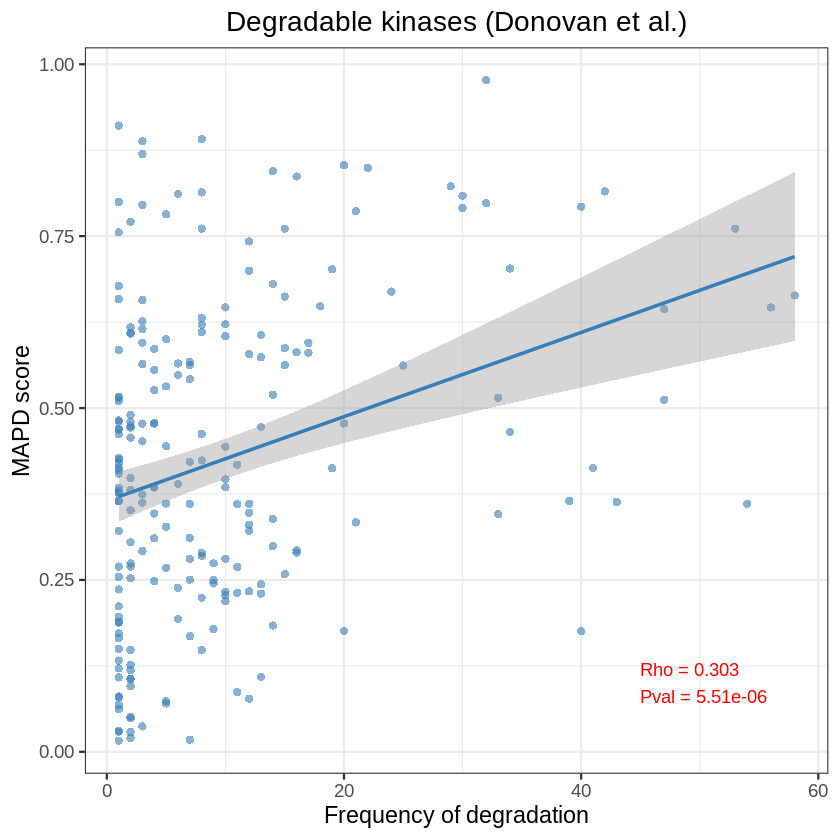

In [3]:
gg = preds[preds$IsKinase=="Yes", ]
gg = as.data.frame(gg)
gg$Gene = rownames(gg)
gg = gg[gg$DegradeFreq>0, ]
test = cor.test(gg$DegradeFreq, gg$MAPD.score, method = "spearman")
p = ScatterView(gg, "DegradeFreq", "MAPD.score", label = "Gene", color = "#377eb8", size = 2,
                xlab = "Frequency of degradation", ylab = "MAPD score", 
                main = paste0("Degradable kinases (Donovan et al.)"))
p = p + geom_smooth(method = "lm", se = TRUE)
p = p + annotate("text", x = 45, y = 0.1, hjust = 0, color = "red",
                    label = paste0("Rho = ", round(test$estimate, 3),
                                   "\nPval = ", format(test$p.value, digits = 3)))
p = p + theme_bw(base_size = 14)
p = p + theme(plot.title = element_text(hjust = 0.5), legend.position = "none")
p

In [4]:
labels = as.integer(as.factor(trainDat$Degradability))
labels[labels==2] = 0
pr <- pr.curve(weights.class0  = labels, scores.class0 = preds[rownames(trainDat), 1], curve = TRUE) 
names(pr)[2] = "auc"
pr = as.data.frame(pr$curve)
colnames(pr) = c("Recall", "Precision", "Threshold")
pr$Threshold[which.max(pr$Recall * pr$Precision)]

[1] 0.2327

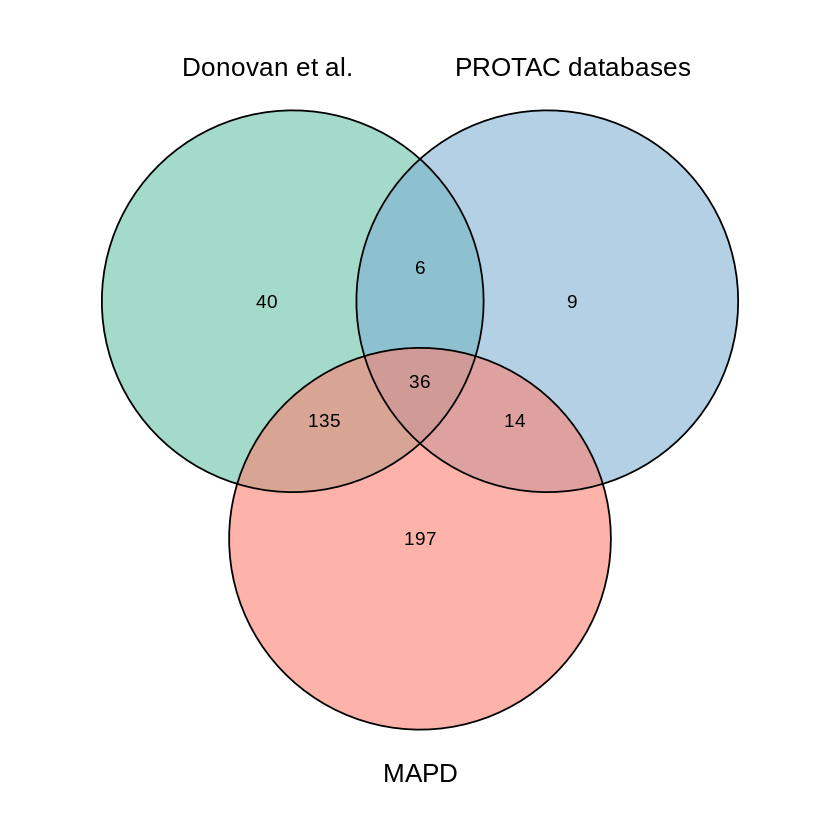

In [5]:
Donovan_Degradable = rownames(preds)[preds$DegradeFreq>0 & preds$IsKinase=="Yes"]
PROTAC_Targets = rownames(preds)[(preds$PROTACdb=="Yes" | preds$PROTACpedia=="Yes") & preds$IsKinase=="Yes"]
MAPD_Degradable = rownames(preds)[preds[,1]>=0.2327 & preds$IsKinase=="Yes"]
gg = list(Donovan_Degradable = Donovan_Degradable, PROTAC_Targets = PROTAC_Targets,
          MAPD_Degradable = MAPD_Degradable)
names(gg) = c("Donovan et al.", "PROTAC databases", "MAPD")
p = ggvenn(gg, fill_color = c("#66c2a5", "#80b1d3", "#fb8072"), show_percentage = FALSE,
           stroke_size = 0.5, set_name_size = 5.5, fill_alpha = 0.6)
p

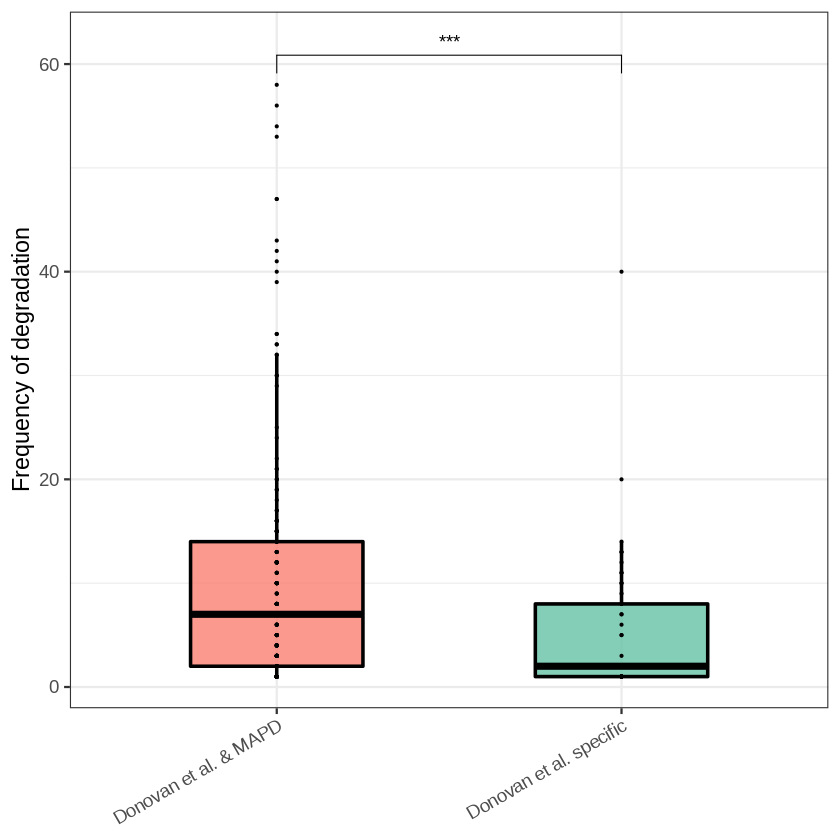

In [6]:
tmp1 = setdiff(Donovan_Degradable, MAPD_Degradable)
tmp2 = intersect(Donovan_Degradable, MAPD_Degradable)

gg = preds[c(tmp1, tmp2), ]
gg$Group = rep(c("Donovan et al. specific", "Donovan et al. & MAPD"), c(length(tmp1), length(tmp2)))
p = BoxView(gg, "Group", "DegradeFreq", fill = "Group", xlab = NULL, ylab = "Frequency of degradation",
            comparisons = list(c("Donovan et al. specific", "Donovan et al. & MAPD")), alpha = 0.8)
p = p + geom_point(size = 0.5)
p = p + scale_fill_manual(values = c("#fb8072", "#66c2a5", "#8da0cb"))
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 62)
p

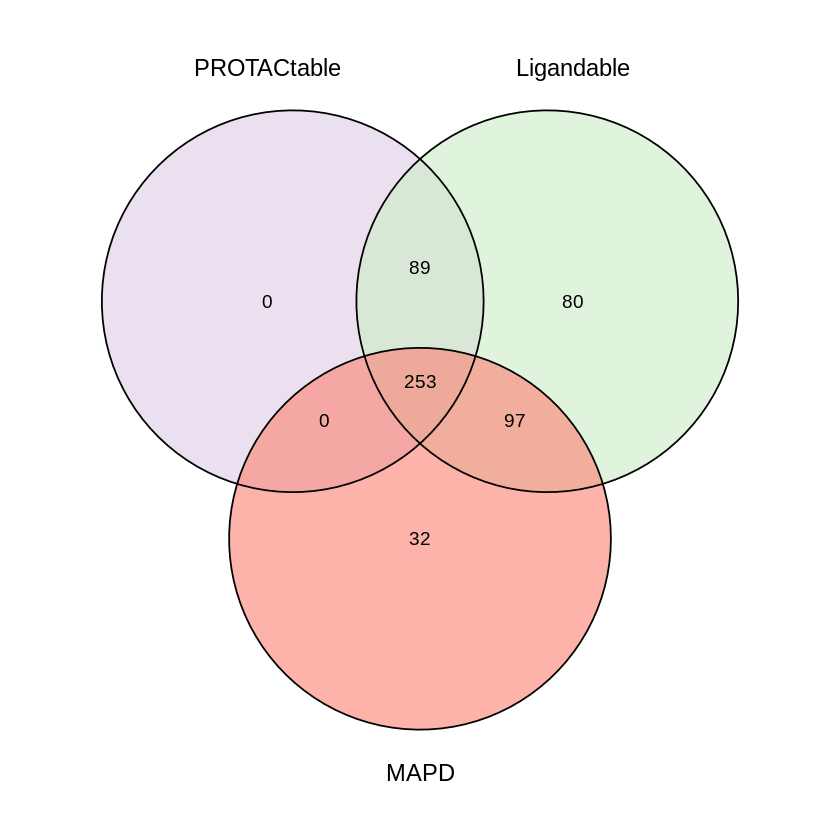

In [7]:
ChEMBL = rownames(preds)[preds$ChEMBL=="Yes" & preds$IsKinase=="Yes"]
SLCABPP = rownames(preds)[preds$Electrophiles=="Yes" & preds$IsKinase=="Yes"]
DrugBank = rownames(preds)[preds$DrugBank=="Yes" & preds$IsKinase=="Yes"]
PROTACtable = rownames(preds)[preds$PROTACtable=="Yes" & preds$IsKinase=="Yes"]
Ligandable = unique(c(ChEMBL, SLCABPP, Donovan_Degradable, DrugBank, PROTAC_Targets))
gg = list(PROTACtable = PROTACtable, Ligandable=Ligandable, MAPD = MAPD_Degradable)
p = ggvenn(gg, fill_color = c("#decbe4", "#ccebc5", "#fb8072"), show_percentage = FALSE,
           stroke_size = 0.5, set_name_size = 5, fill_alpha = 0.6)
p

Warning message in if (is.na(fill)) boo2 = TRUE:
“the condition has length > 1 and only the first element will be used”
Warning message in if (fill %in% colnames(gg)) p = p + geom_boxplot(aes_string(fill = fill), :
“the condition has length > 1 and only the first element will be used”


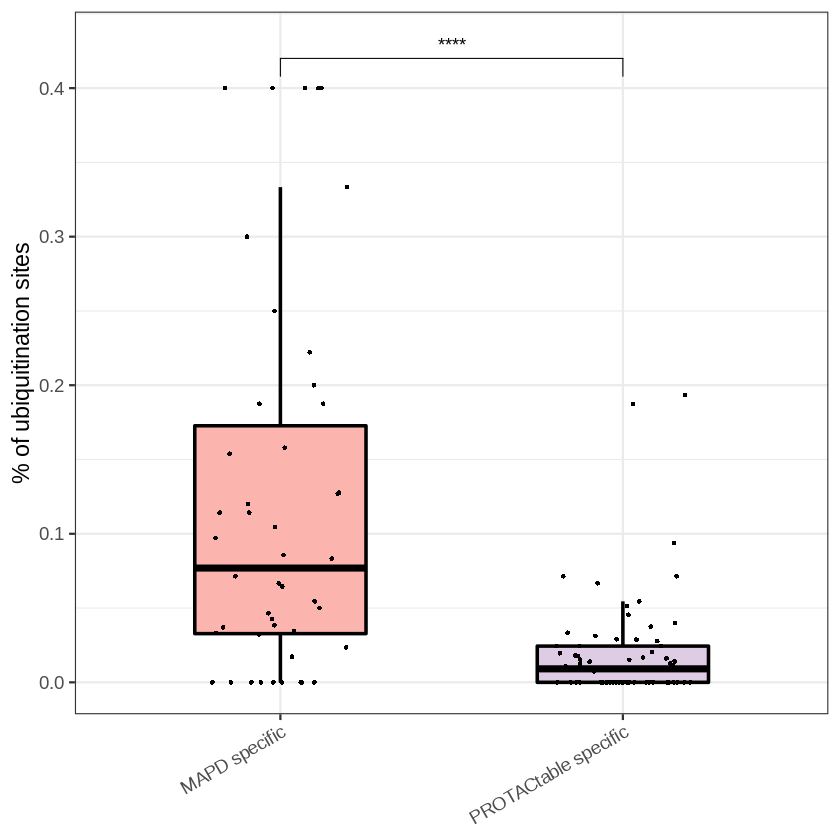

In [8]:
MAPD_specific = setdiff(intersect(MAPD_Degradable, Ligandable), PROTACtable)
PROTACtable_specific = setdiff(PROTACtable, intersect(MAPD_Degradable, Ligandable))

gg = FeatureDat[c(MAPD_specific, PROTACtable_specific), ]
gg$Group = "MAPD specific"
gg$Group[rownames(gg)%in%PROTACtable_specific] = "PROTACtable specific"
gg = gg[gg$Detectability>0.1, ]
gg$Ubiquitination_2[gg$Ubiquitination_2>0.4] = 0.4
p = BoxView(gg, "Group", "Ubiquitination_2", comparisons = list(c("MAPD specific", "PROTACtable specific")),
            fill = c("#fbb4ae", "#decbe4"), xlab = NULL, ylab = "% of ubiquitination sites", add.jitter = TRUE)
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1))
p = p + ylim(NA, 0.43)
p

In [9]:
colnames(preds)

[1] "MAPD.score"            "Feature.completness"   "Max.degradation"      
 [4] "DegradeFreq"           "UniqDegradeFreq"       "DegradeFreq_CRBN"     
 [7] "IsKinase"              "PROTACdb"              "PROTACpedia"          
[10] "Multi.kinase.degrader" "PROTACtable"           "DrugBank"             
[13] "ChEMBL"                "Electrophiles"         "TF"                   
[16] "OncoKB"                "Clinvar"

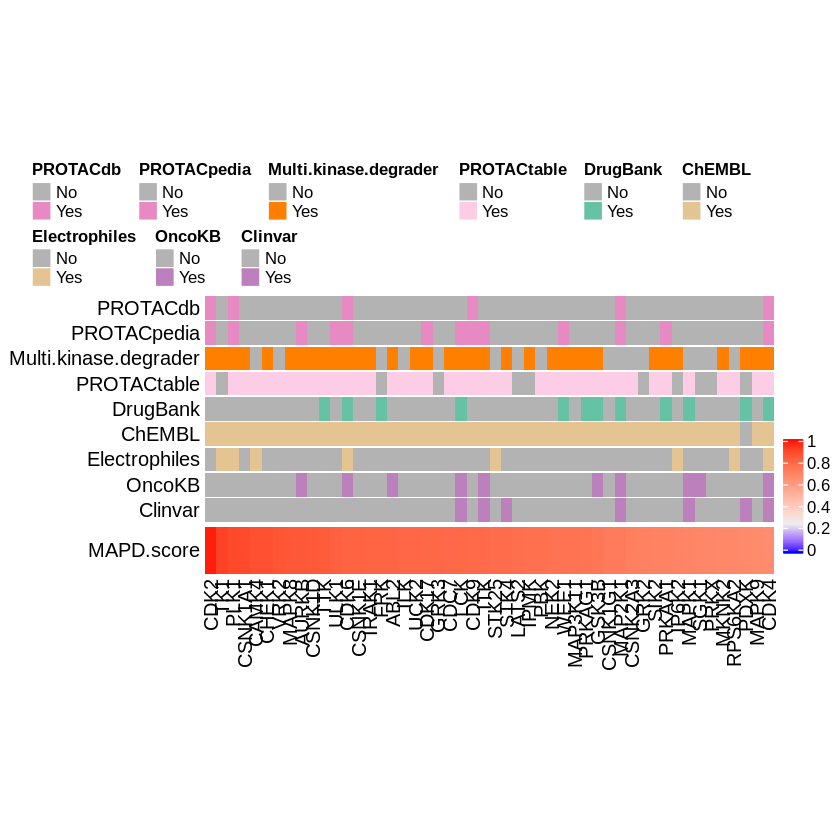

In [10]:
KinGG = preds[preds$IsKinase=="Yes", ][1:50, -c(2:7,15,18)]

col = circlize::colorRamp2(c(0, 0.25, 1), c("blue", "#EEEEEE", "red"))
ha = HeatmapAnnotation(df = KinGG[,-1], annotation_name_side = "left",
                       col = list("PROTACdb" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "PROTACpedia" = c("Yes" = "#e78ac3", "No" = "#b3b3b3"),
                                  "Multi.kinase.degrader" = c("Yes" = "#ff7f00", "No" = "#b3b3b3"),
                                  "PROTACtable" = c("Yes" =  "#fccde5", "No" = "#b3b3b3"),
                                  "DrugBank" = c("Yes" =  "#66c2a5", "No" = "#b3b3b3"),
                                  "ChEMBL" = c("Yes" =  "#e5c494", "No" = "#b3b3b3"),
                                  "Electrophiles" = c("Yes" =  "#e5c494", "No" = "#b3b3b3"),
                                  "TF" = c("Yes" =  "#80b1d3", "No" = "#b3b3b3"),
                                  "OncoKB" = c("Yes" =  "#bc80bd", "No" = "#b3b3b3"),
                                  "Clinvar" = c("Yes" =  "#bc80bd", "No" = "#b3b3b3")))
p = Heatmap(t(KinGG[,1,drop=FALSE]), col = col, name = " ", row_names_side = "left", 
            cluster_columns = FALSE, top_annotation = ha, height = unit(1, "cm"))
draw(p, annotation_legend_side = "top")